In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import plotly.express
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Button, Slider
import plotly.graph_objects as go
import math
import cv2
import os
from PIL import Image
from ipywidgets import interact, fixed, widgets, interact_manual

In [2]:
def show_img_and_filter(x):
    return Image.fromarray(np.array(x).astype(np.uint8))

In [3]:
class DoG():
    
    def __init__(self, sigma1, sigma2, kernel_size=3, stride=1, mode="on_center_off_surround"):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.kernel_size = kernel_size
        self.stride = stride
        self.mode = mode
        self.dict_mode = {"on_center_off_surround": 1, "off_center_on_surround": -1}
    
    def DoGFilter(self):
        self.filt = torch.zeros((self.kernel_size, self.kernel_size))
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                x = i
                y = j
                x = x - (self.kernel_size - 1) / 2
                y = y - (self.kernel_size - 1) / 2
                sum_x_y = -1 * ((x**2) + (y**2)) / 2
                dog1 = (np.e ** (sum_x_y / (self.sigma1**2))) / self.sigma1
                dog2 = (np.e ** (sum_x_y / (self.sigma2**2))) / self.sigma2
                self.filt[i][j] = (1 / np.sqrt(2 * np.pi)) * (dog1 - dog2) * self.dict_mode[self.mode]
        mean_filt = torch.sum(self.filt) / (self.kernel_size * self.kernel_size)
        self.filt -= mean_filt
        return self.filt

    def show_filter(self):
        filter_show = self.filt
        filter_show = filter_show - filter_show.min()
        filter_show = filter_show / filter_show.max()
        filter_show = filter_show * 255
        filter_show = cv2.resize(np.array(filter_show), (224, 224))
        return show_img_and_filter(filter_show)
        
    def show_convolved_image(self, img):
        image = img.clone()
        image -= image.min()
        image /= image.max()
        image *= 255
        return show_img_and_filter(image)
    
    def convolve_DoG(self, img):
        pad = (self.kernel_size-1)//2
        image = torch.nn.functional.pad(input=img, pad=[pad, pad, pad, pad])
        
        final_img = torch.zeros(img.shape[0]//self.stride, img.shape[1]// self.stride)
        stride_x = 0
        for i in range(final_img.shape[0]):
            stride_y = 0
            for j in range(final_img.shape[1]):
                final_img[i][j] = torch.sum(image[stride_x:stride_x+self.kernel_size, stride_y:stride_y+self.kernel_size] * self.filt)#, dtype=torch.uint8)
                stride_y += self.stride
            stride_x += self.stride

        return final_img

In [4]:
face_path = 'faces/'
motor_path = 'Motorbikes/'

In [5]:
face_img_path = os.path.join(face_path, 'image_0001.jpg')
motor_img_path = os.path.join(motor_path, 'image_0001.jpg')

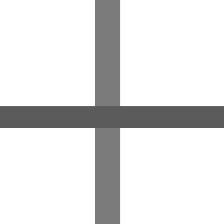

In [6]:
image_path = 'plus.png'
img_orginal = Image.open(image_path).convert('L')
# cv2.imwrite("project7_assets/original.png", np.array(img_orginal))
img_orginal = cv2.resize(np.array(img_orginal), (224, 224))
img_orginal = np.array(img_orginal, 'f')
img_orginal = torch.from_numpy(img_orginal)
show_img_and_filter(img_orginal)

In [7]:
@interact(
    kernel_size=[3,5,7,9,11,13,15,17,33,65],    
    sigma1=widgets.FloatSlider(min=0, max=10, step=0.1, value=2.),
    sigma2=widgets.FloatSlider(min=0, max=10, step=0.1, value=9.),)

def gabor_interactive(kernel_size, sigma1, sigma2):
    dog = DoG(kernel_size=kernel_size, sigma1=sigma1, sigma2=sigma2)
    filt_dog = dog.DoGFilter()
    filter_dog = filt_dog.clone()
    filter_dog -= filter_dog.min()
    filter_dog /= filter_dog.max()
    filter_dog *= 255
    filter_dog = cv2.resize(np.array(filter_dog), (224, 224))
    convolved_img = dog.convolve_DoG(img_orginal)
    plt.imshow(filt_dog)
    print(filt_dog)
    
    display(show_img_and_filter(np.concatenate((filter_dog, np.array(convolved_img)), axis=1)))

interactive(children=(Dropdown(description='kernel_size', options=(3, 5, 7, 9, 11, 13, 15, 17, 33, 65), value=…

In [8]:
img_color = cv2.imread(image_path)
img_color = cv2.resize(img_color, (224, 224))
img_color = np.array(img_color, 'f')
img_color = torch.from_numpy(img_color)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


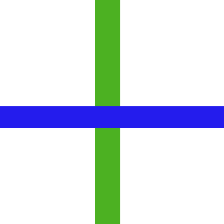

In [9]:
show_img_and_filter(img_color)

In [145]:
img_color_motor = cv2.imread(motor_img_path)
img_color_motor = cv2.resize(img_color_motor, (224, 224))
img_color_motor = np.array(img_color_motor, 'f')
img_color_motor = torch.from_numpy(img_color_motor)

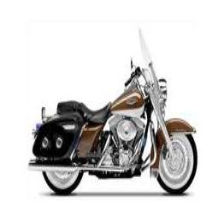

In [146]:
show_img_and_filter(img_color_motor)

In [147]:
img_color.shape   # 0:blue , 1:green , 2:red

torch.Size([224, 224, 3])

In [226]:
class Color_DoG(DoG):
    
    def __init__(self, sigma1, sigma2, kernel_size=3, stride=1, mode="on_center_off_surround", channel_mode="RG"):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.kernel_size = kernel_size
        self.stride = stride
        self.mode = mode
        self.dict_mode = {"on_center_off_surround": 1, "off_center_on_surround": -1}
        self.channel_mode = channel_mode
        self.ch_dict = {"RG":[2, 1], "GR":[1, 2], "BY":[0, 1, 2], "YB":[1, 2, 0]}
    
    def DoGFilter(self):
        self.filt = torch.zeros((self.kernel_size, self.kernel_size, 3))
        sigma_lst = [self.sigma1, self.sigma2, self.sigma2]
        if self.channel_mode == "YB":
            sigma_lst = [self.sigma1, self.sigma1, self.sigma2] 
        for c in range(len(self.ch_dict[self.channel_mode])):
            for i in range(self.kernel_size):
                for j in range(self.kernel_size):
                    x = i
                    y = j
                    x = x - (self.kernel_size - 1) / 2
                    y = y - (self.kernel_size - 1) / 2
                    sum_x_y = -1 * ((x**2) + (y**2)) / 2
                    dog = (np.e ** (sum_x_y / (sigma_lst[c]**2))) / sigma_lst[c]
                    self.filt[i][j][self.ch_dict[self.channel_mode][c]] = (1 / np.sqrt(2 * np.pi)) * (dog)

            mean_filt = torch.sum(self.filt[:,:,self.ch_dict[self.channel_mode][c]]) / (self.kernel_size * self.kernel_size)
            self.filt[:,:,self.ch_dict[self.channel_mode][c]]-= mean_filt
            
            # self.filt = torch.ones((3,3,3)) * -1
            # self.filt[1,1,0] = 8
            # self.filt[1,1,1] = 8
        
        
        return self.filt * self.dict_mode[self.mode]
    
    def convolve_DoG(self, img):
        pad = (self.kernel_size-1)//2
        # image = torch.nn.functional.pad(input=img, pad=(0, 0, pad, pad, pad, pad))
        image = img.clone()
        plt.imshow(img)
        
        final_img = torch.zeros((img.shape[0]-self.kernel_size + 1)//self.stride, (img.shape[1]-self.kernel_size + 1)//self.stride, 3)
        
        for c in range(len(self.ch_dict[self.channel_mode])):
            stride_x = 0
            for i in range(final_img.shape[0]):
                stride_y = 0
                for j in range(final_img.shape[1]):
                    apply_filter = torch.sum(image[stride_x:stride_x+self.kernel_size, stride_y:stride_y+self.kernel_size, self.ch_dict[self.channel_mode][c]] *
                                             self.filt[:,:,self.ch_dict[self.channel_mode][c]] * self.dict_mode[self.mode])
                    final_img[i][j][self.ch_dict[self.channel_mode][c]] = apply_filter
                    stride_y += self.stride
                stride_x += self.stride

        return final_img

In [227]:
dog = Color_DoG(sigma1=2, sigma2=5, kernel_size=3, mode="off_center_on_surround", channel_mode="RG")
dog_filter = dog.DoGFilter()

In [229]:
dog_filter#[:,:,0]

tensor([[[-0.0000,  0.0010,  0.0141],
         [-0.0000, -0.0005, -0.0066],
         [-0.0000,  0.0010,  0.0141]],

        [[-0.0000, -0.0005, -0.0066],
         [-0.0000, -0.0021, -0.0300],
         [-0.0000, -0.0005, -0.0066]],

        [[-0.0000,  0.0010,  0.0141],
         [-0.0000, -0.0005, -0.0066],
         [-0.0000,  0.0010,  0.0141]]])

In [230]:
a = torch.zeros((5, 5, 3))
a[2,2,0] = 255 #red
a[:,:,1] = 255 #green
a[2,2,1] = 0
# print(a)
show_img_and_filter(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


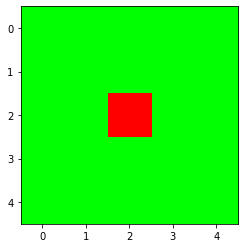

In [231]:
convolved_img = dog.convolve_DoG(a)
show_img_and_filter(convolved_img)
# dog.show_convolved_image(convolved_img)

In [232]:
convolved_img.shape

torch.Size([3, 3, 3])

In [233]:
def res_conv(conv):
    conv[(conv < 1.0e-05) & ( conv > 0)] =0
    return conv

In [234]:
res_conv(convolved_img[:,:,1])

tensor([[-0.2642,  0.1307, -0.2642],
        [ 0.1307,  0.5336,  0.1307],
        [-0.2642,  0.1307, -0.2642]])

In [235]:
conv = res_conv(convolved_img[:,:,0]) + res_conv(convolved_img[:,:,1])
conv

tensor([[-0.2642,  0.1307, -0.2642],
        [ 0.1307,  0.5336,  0.1307],
        [-0.2642,  0.1307, -0.2642]])

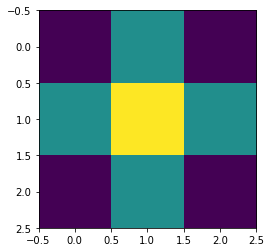

In [236]:
plt.imshow(conv)

In [237]:
conv_Y = (convolved_img[:,:,1] + convolved_img[:,:,2]) / 2.
conv_B = convolved_img[:,:,0]
res = conv_B - conv_Y
res_conv(res)

tensor([[ 0.1321, -0.0654,  0.1321],
        [-0.0654, -0.2668, -0.0654],
        [ 0.1321, -0.0654,  0.1321]])

In [238]:
show_img_and_filter(res_conv(conv)*255)

In [245]:
def show_conv_img(img_color):
    ch_mode = ["RG", "GR", "BY", "YB"]
    fig, axs = plt.subplots(2,4, figsize=(15, 15))
    axs = axs.ravel()
    for i in range(len(ch_mode)):
        dog = Color_DoG(sigma1=2, sigma2=5, kernel_size=5, mode="on_center_off_surround", channel_mode = ch_mode[i])
        dog_filter = dog.DoGFilter()
        convolved_img = dog.convolve_DoG(img_color)
        # print("=============="+ch_mode[i]+"============")
        if ch_mode[i] == "RG":
            conv = (convolved_img[:,:,2] + convolved_img[:,:,1])
            res = res_conv(conv)
        if ch_mode[i] == "GR":
            conv = (convolved_img[:,:,1] + convolved_img[:,:,2])
            res = res_conv(conv)
        if ch_mode[i] == "BY":
            conv_Y = (convolved_img[:,:,1] + convolved_img[:,:,2]) / 2.
            conv_B = convolved_img[:,:,0]
            res = conv_B + conv_Y
            res = res_conv(res)
        if ch_mode[i] == "YB":
            conv_Y = (convolved_img[:,:,1] + convolved_img[:,:,2]) / 2.
            conv_B = convolved_img[:,:,0]
            res = conv_Y + conv_B
            res = res_conv(res)
        print(res[125,50])
        axs[i].set_title(ch_mode[i])
        axs[i].imshow(convolved_img)
        axs[i+4].imshow(res*255, cmap="gray")

In [246]:
#show_conv_img(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1881)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.3431)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.2349)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.2633)


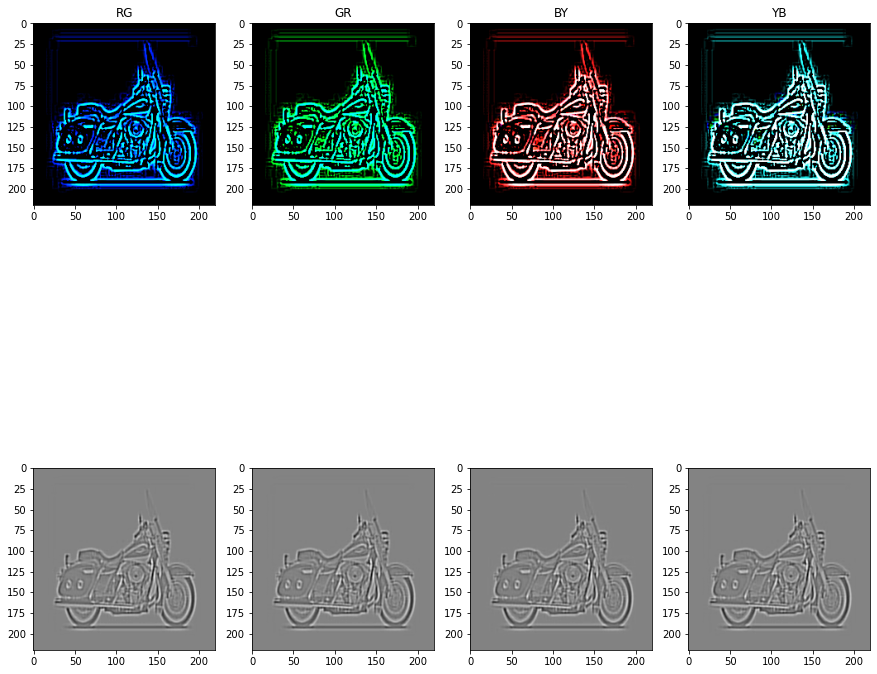

In [247]:
show_conv_img(img_color_motor)

In [105]:
from numpy import unravel_index
unravel_index(res_conv(conv).argmax(), res_conv(conv).shape)

(1, 1)